In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d omarradi/three-brain-neurological-classes-mri-scans

Dataset URL: https://www.kaggle.com/datasets/omarradi/three-brain-neurological-classes-mri-scans
License(s): other
 95% 553M/579M [00:01<00:00, 331MB/s]
100% 579M/579M [00:01<00:00, 420MB/s]


In [ ]:
!unzip -q /content/three-brain-neurological-classes-mri-scans.zip -d /content/mri_dataset


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import DenseNet121, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model



/tmp/ipython-input-1018638004.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [ ]:
# =========================
# IMPORTS
# =========================
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
data_path = "/content/mri_dataset"
file_types = ['jpeg','jpg','png']

removed = 0
for root,dirs,files in os.walk(data_path):
    for file in files:
      file_path = os.path.join(root,file)

      try:
        file_type = imghdr.what(file_path)
        if file_type not in file_types:
          print(f'file not exist in list {file_path}')
          os.remove(file_path)
          removed += 1
      except Exception as e:
        print(f'Issue with file {file_path}')
        os.remove(file_path)
        removed += 1
print(f'\nTotal files removed from {data_path}: {removed}')


Total files removed from /content/mri_dataset: 0


In [ ]:
root_folder = '/content/mri_dataset/'

results = []

for class_name in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_name)
    if os.path.isdir(class_path):
        rgb_count = 0
        rgba_count = 0
        grayscale_count = 0

        for filename in os.listdir(class_path):
          img_path = os.path.join(class_path, filename)
          img = Image.open(img_path)
          mode = img.mode
          if mode == 'RGB':
              rgb_count += 1
          elif mode == 'RGBA':
              rgba_count += 1
          elif mode == 'L':
              grayscale_count += 1

        results.append({
            'Class': class_name,
            'RGB': rgb_count,
            'RGBA': rgba_count,
            'Grayscale': grayscale_count
        })

df = pd.DataFrame(results)
print(df)


                               Class   RGB  RGBA  Grayscale
0       Alzehaimer Dementia 2nd Mild   896     0          0
1          3rd Brain Tumor Pituitary  3490     0          0
2             1st Brain Tumor Glioma  3000     0          0
3                 Multiple Sclerosis  3195     0          0
4  Alzehaimer Dementia 1st Very Mild  2240     0          0
5   Alzehaimer Dementia 3rd Moderate   503     0          0
6         2nd Brain Tumor Meningioma  3160     0          0
7                             Normal  8104     0          0


In [ ]:
import os
from PIL import Image

root_folder = '/content/mri_dataset/'

for class_name in os.listdir(root_folder):
    class_path = os.path.join(root_folder, class_name)

    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            try:
                with Image.open(img_path) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                        img.save(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print("✅ All images converted to RGB successfully.")


✅ All images converted to RGB successfully.


In [ ]:
def count_files_in_dir(dir):
  count = {}

  for item in os.listdir(dir):
    item_path = os.path.join(dir,item)
    if os.path.isdir(item_path):
      count[item] = len(os.listdir(item_path))

  df = pd.DataFrame(list(count.items()), columns=["Class", "Count"])
  return df


data_path = "/content/mri_dataset"
count = count_files_in_dir(data_path)
print('\nImages in each class :\n',count)


Images in each class :
                                Class  Count
0       Alzehaimer Dementia 2nd Mild    896
1          3rd Brain Tumor Pituitary   3490
2             1st Brain Tumor Glioma   3000
3                 Multiple Sclerosis   3195
4  Alzehaimer Dementia 1st Very Mild   2240
5   Alzehaimer Dementia 3rd Moderate    503
6         2nd Brain Tumor Meningioma   3160
7                             Normal   8104


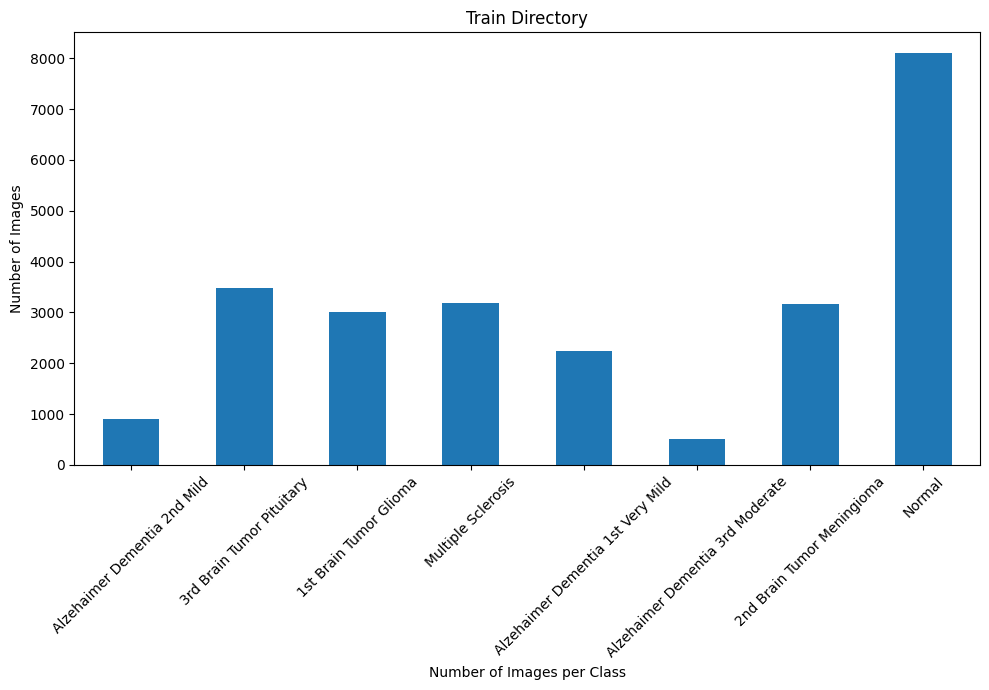

In [ ]:
fig,axes = plt.subplots(figsize=(10,7))


count.plot(x='Class',y='Count',kind='bar',legend=False,ax=axes)
axes.set_ylabel('Number of Images')
axes.set_xlabel('Number of Images per Class')
axes.set_title('Train Directory')
axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

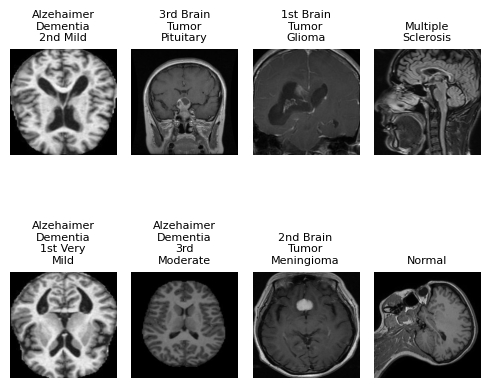

In [ ]:
import textwrap

data_path = "/content/mri_dataset"
disorders = os.listdir(data_path)

fig,axes = plt.subplots(2,4,figsize=(5,5))
axes = axes.flatten()

for i,disorder in enumerate(disorders):
  folder = os.path.join(data_path,disorder)
  img_path = os.path.join(folder,os.listdir(folder)[42])
  img = Image.open(img_path)
  axes[i].imshow(img,cmap='gray')
  axes[i].set_title("\n".join(textwrap.wrap(disorder, 10)), fontsize=8)  # wrap every 10 chars
  axes[i].axis('off')

for j in range(len(disorder), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def image_to_array(image_path):
    try:
        with Image.open(image_path) as img:
            image_array = np.array(img)
            return image_array
    except IOError:
        print(f"Could not read the image file at {image_path}.")
        return None

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
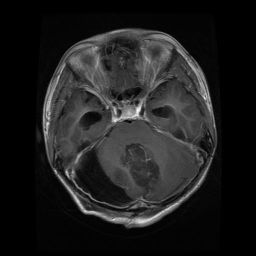

In [ ]:
image_to_array('/content/mri_dataset/1st Brain Tumor Glioma/BT Glioma 1.jpg')

In [ ]:

# =========================
# CONFIG
# =========================
DATASET_PATH = "/content/mri_dataset"
SAVE_PATH = "/content/temp"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS_STAGE1 = 20
EPOCHS_STAGE2 = 12
SEED = 42

AUTOTUNE = tf.data.AUTOTUNE


In [ ]:
# =========================
# CLASS NAMES
# =========================
class_names = [
    "1st Brain Tumor Glioma",
    "2nd Brain Tumor Meningioma",
    "3rd Brain Tumor Pituitary",
    "Alzehaimer Dementia 1st Very Mild",
    "Alzehaimer Dementia 2nd Mild",
    "Alzehaimer Dementia 3rd Moderate",
    "Multiple Sclerosis",
    "Normal"
]

NUM_CLASSES = len(class_names)



In [ ]:

# =========================
# LOAD DATA
# =========================
image_paths, labels = [], []

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    for img in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, img))
        labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)




In [ ]:
# =========================
# SPLIT
# =========================
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)


In [ ]:
# =========================
# IMAGE LOADER
# =========================
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    return img, tf.one_hot(label, NUM_CLASSES)





In [ ]:
# =========================
# DATASETS
# =========================
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(2000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)




In [ ]:
# =========================
# DATA AUGMENTATION
# =========================
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.15),
])



In [ ]:

# =========================
# FOCAL LOSS
# =========================
def categorical_focal_loss(gamma=2.5, alpha=0.5):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        fl = weight * ce
        return tf.reduce_mean(tf.reduce_sum(fl, axis=1))
    return loss



In [ ]:
# =========================
# CLASS WEIGHTS
# =========================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))



In [ ]:
# =========================
# MODEL (RESNET50)
# =========================
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)

x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# File path for the model checkpoint
cnn_path = '/content/temp'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    monitor='val_auc',
    mode='max'
)

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          patience = 4,
                          restore_best_weights = True,
                          verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.3,
    patience=2,
    mode='max',
    min_lr=1e-7,
    verbose=1
)


# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, reduce_lr, earlystop, csv_logger] # Adjusted as per your use-case

In [ ]:
model.compile(
    optimizer=Adam(1e-4),
    loss=categorical_focal_loss(),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            multi_label=True,
            num_labels=NUM_CLASSES,
            name="auc"
        )
    ]
)



model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks,
    class_weight=class_weights
)



Epoch 1/20
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5654 - auc: 0.8767 - loss: 0.3243
Epoch 1: val_auc improved from -inf to 0.96606, saving model to /content/temp/ResNet50_Transfer_Learning.keras
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 144s 105ms/step - accuracy: 0.5654 - auc: 0.8767 - loss: 0.3242 - val_accuracy: 0.7509 - val_auc: 0.9661 - val_loss: 0.0994 - learning_rate: 1.0000e-04
Epoch 2/20
1229/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7296 - auc: 0.9571 - loss: 0.1136
Epoch 2: val_auc improved from 0.96606 to 0.97212, saving model to /content/temp/ResNet50_Transfer_Learning.keras
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 123s 99ms/step - accuracy: 0.7296 - auc: 0.9571 - loss: 0.1136 - val_accuracy: 0.7767 - val_auc: 0.9721 - val_loss: 0.0828 - learning_rate: 1.0000e-04
Epoch 3/20
1229/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7626 - auc: 0.9642 - loss: 0.0939
Epoch 3: val_auc improved from 0.97212 to 0.97559, saving model to /content/temp/ResNet50_Transfer_Le

In [ ]:
train_loss, train_accu, train_auc = model.evaluate(train_ds)
val_loss, val_accu, val_auc = model.evaluate(val_ds)

print(
    "Train Accuracy: {:.2f}%, Train AUC: {:.4f}\nValidation Accuracy: {:.2f}%, Validation AUC: {:.4f}"
    .format(train_accu*100, train_auc, val_accu*100, val_auc)
)


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 99s 78ms/step - accuracy: 0.8614 - auc: 0.9854 - loss: 0.0435
308/308 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.8410 - auc: 0.9802 - loss: 0.0559
Train Accuracy: 86.19%, Train AUC: 0.9860
Validation Accuracy: 84.24%, Validation AUC: 0.9832


In [ ]:
# =========================
# FINE-TUNING (LAST 25 LAYERS)
# =========================
for layer in base_model.layers[-35:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss=categorical_focal_loss(),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            multi_label=True,
            num_labels=NUM_CLASSES,
            name="auc"
        )
    ]
)




In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks,
    class_weight=class_weights
)


# =========================
# SAVE MODEL (PERMANENT)
# =========================



Epoch 1/12
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7898 - auc: 0.9706 - loss: 0.0914
Epoch 1: val_auc improved from 0.98389 to 0.98421, saving model to /content/temp/ResNet50_Transfer_Learning.keras
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 191s 142ms/step - accuracy: 0.7898 - auc: 0.9706 - loss: 0.0914 - val_accuracy: 0.8404 - val_auc: 0.9842 - val_loss: 0.0545 - learning_rate: 1.0000e-05
Epoch 2/12
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.8352 - auc: 0.9805 - loss: 0.0543
Epoch 2: val_auc improved from 0.98421 to 0.98619, saving model to /content/temp/ResNet50_Transfer_Learning.keras
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 173s 139ms/step - accuracy: 0.8352 - auc: 0.9805 - loss: 0.0543 - val_accuracy: 0.8512 - val_auc: 0.9862 - val_loss: 0.0503 - learning_rate: 1.0000e-05
Epoch 3/12
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8536 - auc: 0.9835 - loss: 0.0478
Epoch 3: val_auc improved from 0.98619 to 0.98833, saving model to /content/temp/ResNet50_Tran

In [ ]:
train_loss, train_accu, train_auc = model.evaluate(train_ds)
val_loss, val_accu, val_auc = model.evaluate(val_ds)

print(
    "Train Accuracy: {:.2f}%, Train AUC: {:.4f}\nValidation Accuracy: {:.2f}%, Validation AUC: {:.4f}"
    .format(train_accu*100, train_auc, val_accu*100, val_auc)
)

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 98s 76ms/step - accuracy: 0.9580 - auc: 0.9982 - loss: 0.0111
308/308 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9225 - auc: 0.9923 - loss: 0.0281
Train Accuracy: 96.05%, Train AUC: 0.9985
Validation Accuracy: 91.99%, Validation AUC: 0.9952


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================
# EVALUATION
# =========================
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))



                                   precision    recall  f1-score   support

           1st Brain Tumor Glioma       0.99      0.97      0.98       600
       2nd Brain Tumor Meningioma       0.97      0.97      0.97       632
        3rd Brain Tumor Pituitary       0.98      1.00      0.99       698
Alzehaimer Dementia 1st Very Mild       0.78      0.75      0.77       448
     Alzehaimer Dementia 2nd Mild       0.87      0.91      0.89       179
 Alzehaimer Dementia 3rd Moderate       1.00      0.98      0.99       101
               Multiple Sclerosis       0.85      0.95      0.90       639
                           Normal       0.92      0.88      0.90      1621

                         accuracy                           0.92      4918
                        macro avg       0.92      0.93      0.92      4918
                     weighted avg       0.92      0.92      0.92      4918



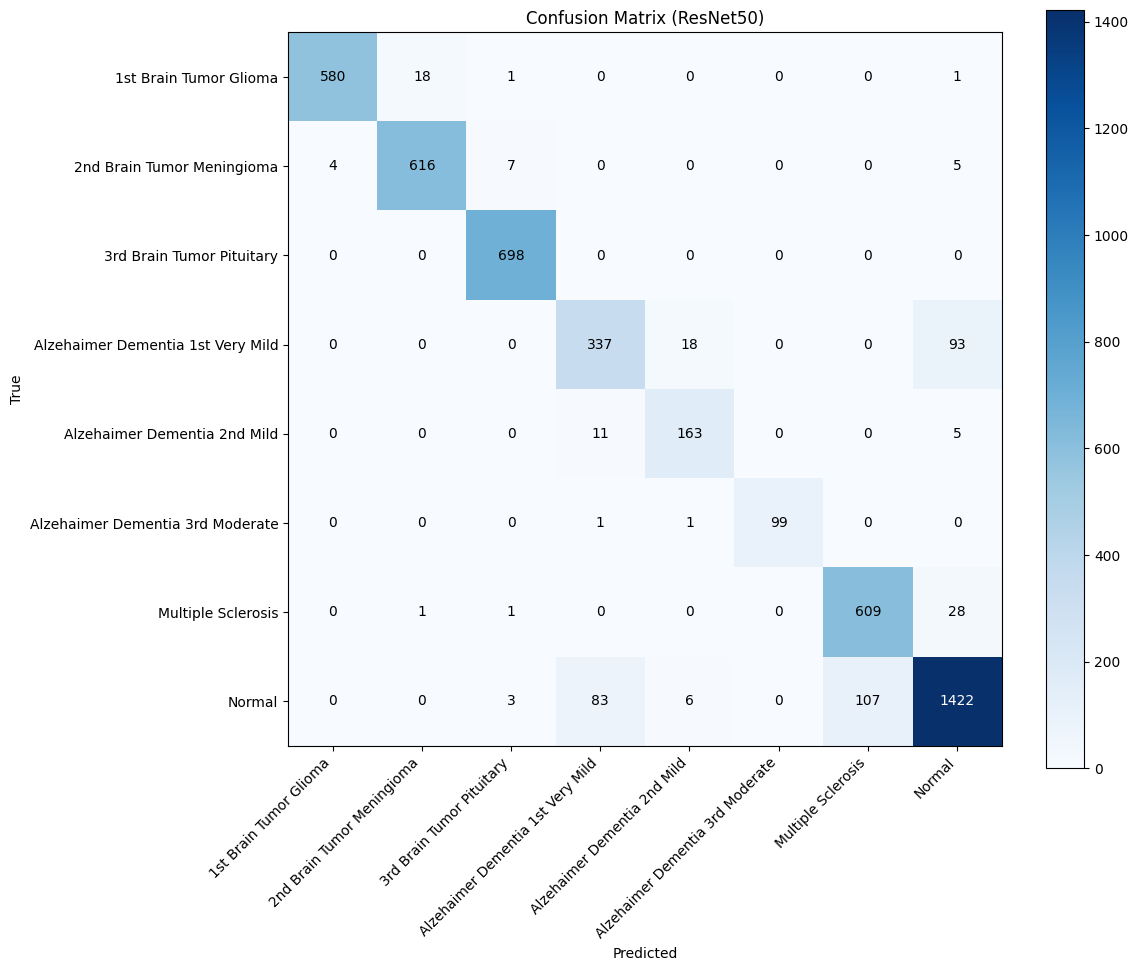

In [ ]:
# =========================
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

plt.xticks(np.arange(NUM_CLASSES), class_names, rotation=45, ha="right")
plt.yticks(np.arange(NUM_CLASSES), class_names)

for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max()/2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ResNet50)")
plt.tight_layout()
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/TS Models/resenet_50_new_dataset_91.keras')

In [ ]:
from tensorflow.keras.models import load_model

m = load_model(
    '/content/drive/MyDrive/TS Models/resenet_50_new_dataset_91.keras',
    compile=False
)


In [ ]:
m.compile(
    optimizer=Adam(1e-5),
    loss=categorical_focal_loss(),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(
            multi_label=True,
            num_labels=NUM_CLASSES,
            name="auc"
        )
    ]
)


In [ ]:
train_loss, train_accu, train_auc = m.evaluate(train_ds)
val_loss, val_accu, val_auc = m.evaluate(val_ds)

print(
    "Train Accuracy: {:.2f}%, Train AUC: {:.4f}\nValidation Accuracy: {:.2f}%, Validation AUC: {:.4f}"
    .format(train_accu*100, train_auc, val_accu*100, val_auc)
)

1230/1230 ━━━━━━━━━━━━━━━━━━━━ 100s 75ms/step - accuracy: 0.9597 - auc: 0.9982 - loss: 0.0108
308/308 ━━━━━━━━━━━━━━━━━━━━ 22s 72ms/step - accuracy: 0.9225 - auc: 0.9923 - loss: 0.0281
Train Accuracy: 96.05%, Train AUC: 0.9985
Validation Accuracy: 91.99%, Validation AUC: 0.9952


In [ ]:
def predict_image(model, image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)

    # use correct preprocessing for ResNet
    img = tf.keras.applications.resnet.preprocess_input(img)

    img = tf.expand_dims(img, axis=0)
    preds = model.predict(img)
    class_id = np.argmax(preds[0])
    confidence = preds[0][class_id]

    return class_names[class_id], confidence

In [ ]:
image_path = "/content/mri_dataset/Normal/27 (48).jpg"

label, conf = predict_image(model, image_path)

print("Predicted:", label)
print("Confidence:", conf)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Predicted: Normal
Confidence: 0.59722644
